In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import matplotlib.ticker as mticker
import matplotlib.dates as mdates
import numpy as np
from datetime import timedelta, datetime

plt.style.use('ggplot')

import mle as mle

### Create data for analysis

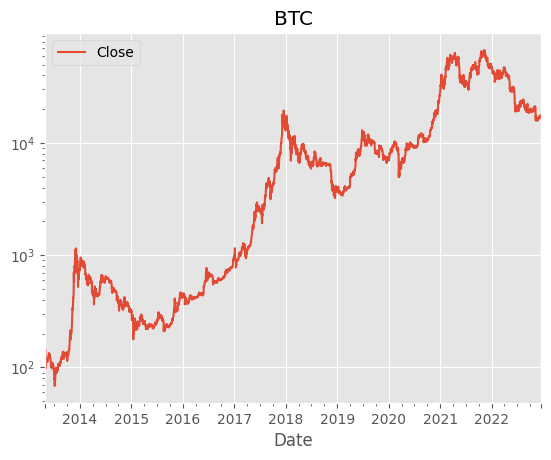

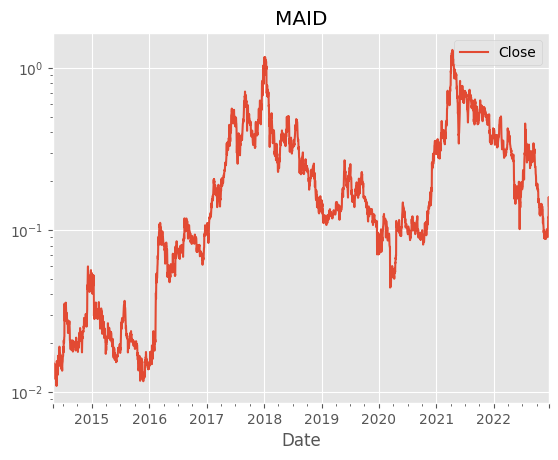

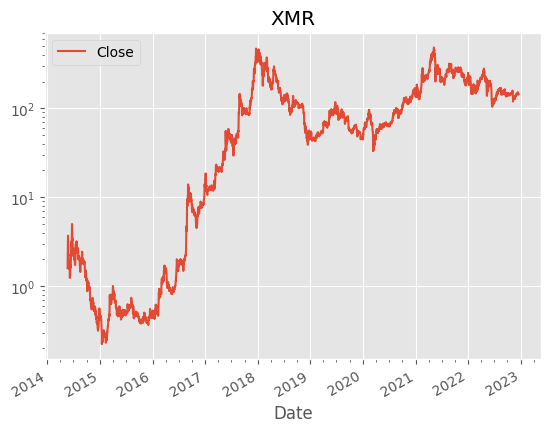

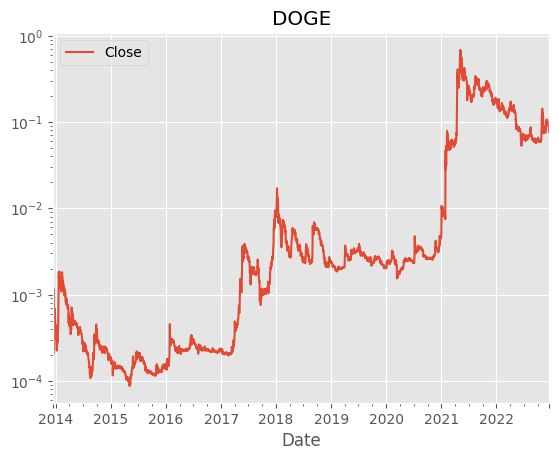

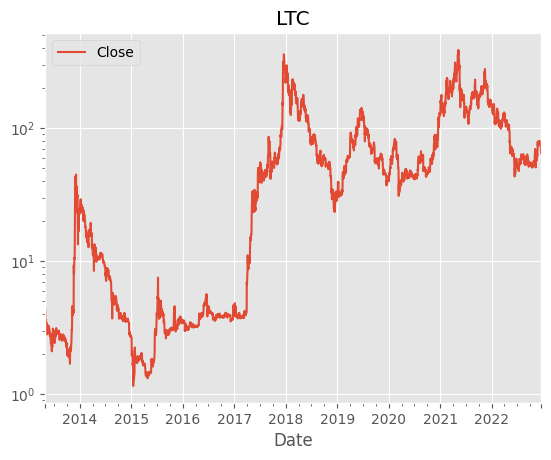

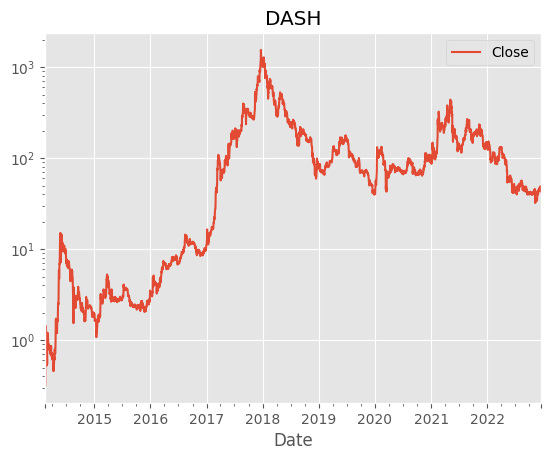

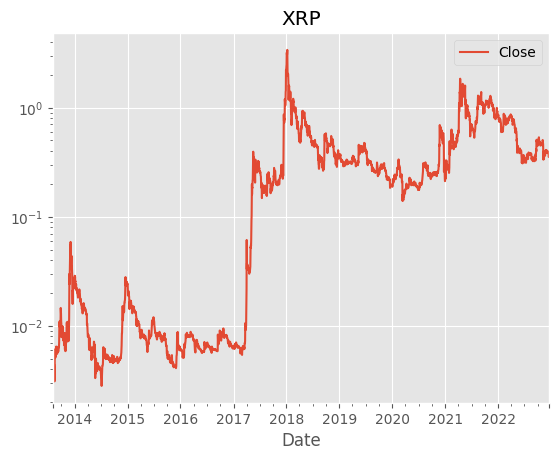

In [2]:
coins = ['BTC', 'MAID', 'XMR', 'DOGE', 'LTC', 'DASH', 'XRP']
dfs = dict()
for coin in coins:
    df = pd.read_csv(f'../data/prices/{coin}.csv').set_index('Date').sort_index()
    df.index = pd.to_datetime(df.index)
    df['log_return'] = np.log(1 + df['Close'].pct_change())
    dfs[coin.lower()] = df

    ax = df[['Close']].plot(logy=True)
    months = mdates.MonthLocator((1,4,7,10))
    ax.xaxis.set_minor_locator(months)
    ax.xaxis.tick_bottom()

    plt.title(coin)
    plt.show()


### Fit models to all data

In [3]:
dists = [mle.Laplace, mle.SkewT, mle.SkewedStudent, mle.GeneralizedT,
 mle.NormalizedInverseGaussian, mle.GeneralizedHyperbolic, mle.StudentT,
 mle.AsymmetricStudentT]
 
end_date = pd.to_datetime('28-02-2017', format='%d-%m-%Y')
start_date =  pd.to_datetime('23-06-2014', format='%d-%m-%Y')

info_list = []

for coin in coins:
    coin_df = dfs[coin.lower()]
    df = coin_df[(coin_df.index>=start_date)&(coin_df.index<=end_date)]
    # df = coin_df
    for dist in dists:

        fitted_dist = dist()
        fitted_dist.mle(df['log_return'])
        info_dict = fitted_dist.info_dict()
        info_dict['coin'] = coin

        info_list.append(info_dict)
info_df = pd.DataFrame(info_list)

c:\Users\George\projects\masters\stats_methods_cw\venv\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\George\projects\masters\stats_methods_cw\venv\lib\site-packages\scipy\optimize\_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
c:\Users\George\projects\masters\stats_methods_cw\george\mle.py:194: RuntimeWarning: overflow encountered in double_scalars
  return (tao/ (2*sigma*nu**(1/tao) * beta(nu,1/tao)))*(1+ 1/nu * np.abs((x-mu)/sigma)**tao)**(-(nu+1/tao))
c:\Users\George\projects\masters\stats_methods_cw\george\mle.py:235: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.pdf(x, mu, delta, alpha, beta)))
c:\Users\George\projects\masters\stats_methods_cw\venv\lib\site-packages\scipy\stats\_continuous_distns.py:4665: RuntimeWarni

### Add qq plots


In [46]:
def qqplot(dist, data):
    qs=list(np.linspace(0.01,0.25, 12))+list(np.linspace(0.26,0.75, 10))+list(np.linspace(0.76,0.99, 12))
    
    quantiles=[]
    for i in qs:
        quantiles.append(dist.quantile(i))
    
    observed_quantiles=np.quantile(data['log_return'].dropna(),qs)
    fig, ax = plt.subplots()
    ax.scatter(quantiles,observed_quantiles)
    return fig, ax

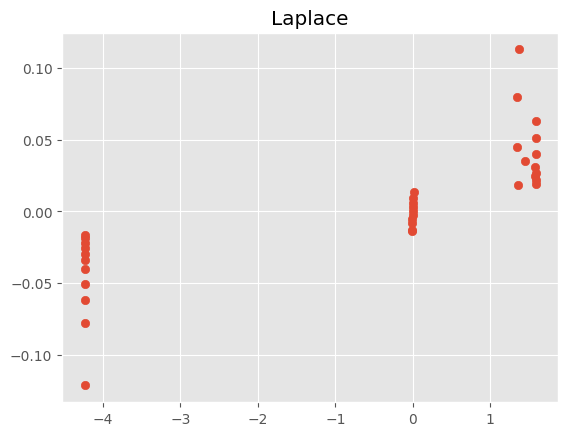

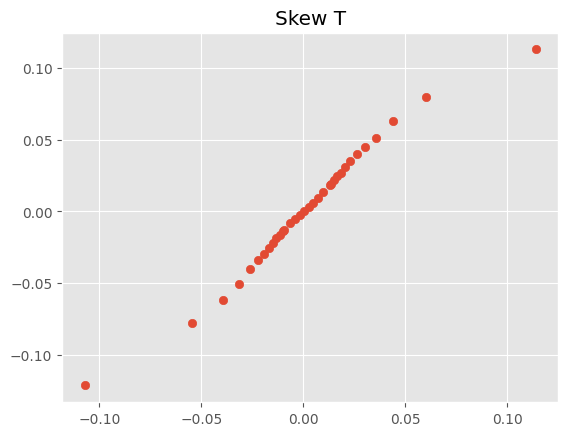

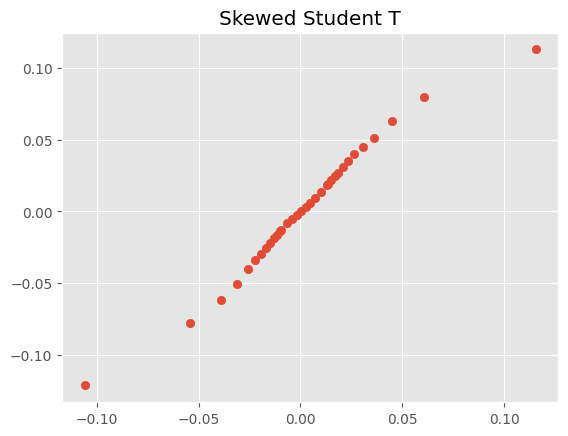

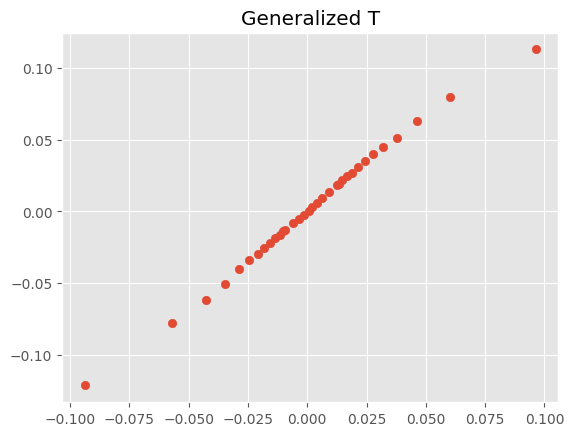

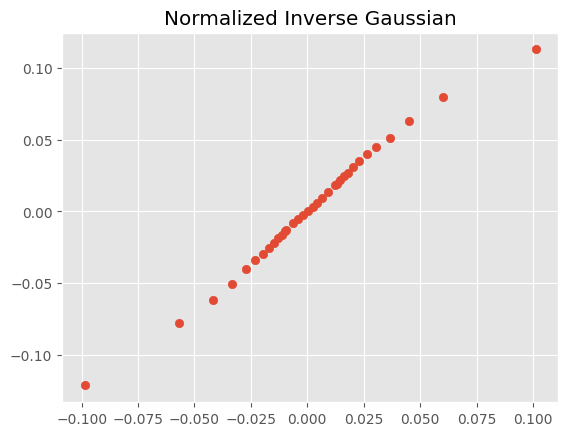

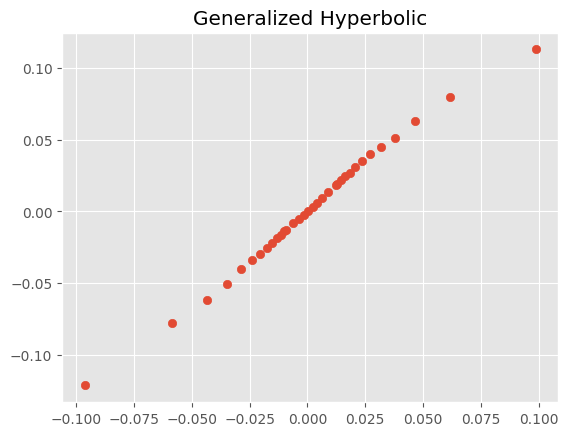

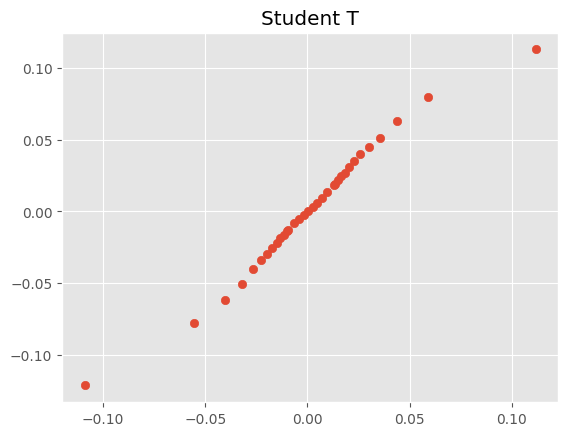

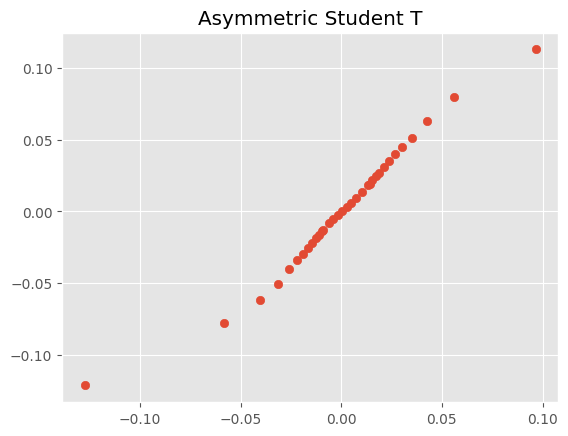

In [47]:
coin = 'BTC'
coin_dists = info_df[info_df['coin']==coin]

for dist in coin_dists['pydist']:
    
    coin_df = dfs[coin.lower()]
    df = coin_df[(coin_df.index>=start_date)&(coin_df.index<=end_date)]
    fig, ax = qqplot(dist, coin_df)
    ax.set_title(dist.name); plt.show()


### Analyse fit stability over time 

- Calculate fit parameters over a rolling window
- Plot data and save to file

In [ ]:
# ~ 9m runtime

info_list = []
jump = 90
start_to_end_days = 981

start_date =  pd.to_datetime('23-06-2014', format='%d-%m-%Y')
end_date = start_date + timedelta(days=start_to_end_days)


while end_date <= datetime.now():

    for coin in coins:
        coin_df = dfs[coin.lower()]
        df = coin_df[(coin_df.index>=start_date)&(coin_df.index<=end_date)]
        # df = coin_df
        for dist in dists:

            fitted_dist = dist()
            fitted_dist.mle(df['log_return'])
            info_dict = fitted_dist.info_dict()
            info_dict['coin'] = coin
            info_dict['start_date'] = start_date
            info_dict['end_date'] = end_date


            info_list.append(info_dict)

    start_date =  start_date + timedelta(days=jump)
    end_date = start_date + timedelta(days=start_to_end_days)


In [ ]:
params_over_time = pd.DataFrame(info_list)

for coin in coins:

    tmp = params_over_time[params_over_time['coin']==coin]
    tmp = tmp[['end_date', 'dist','AIC']].set_index('end_date')
    tmp = tmp.pivot(columns='dist')

    tmp.columns = [col[1] for col in tmp.columns]

    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(8,8))

    ax1 = tmp.plot(ax=ax1)
    ax1.set_title(f"{coin.upper()}")
    ax1.set_ylabel('AIC')
    ax1.legend(loc=2,fontsize=8)

    ax2 = tmp.rank(axis=1).plot(ax=ax2)
    ax2.set_ylabel('Ranking')
    ax2.set_xlabel('End Date')
    ax2.get_legend().remove()

    plt.savefig(f'../plots/fit_over_time/{coin}.png'); plt.clf()